In [35]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="D:\\6_sem\\bigdata\\esoteric-bruin-379522-1ac227ab6db1.json"
client = bigquery.Client()

pd.set_option('display.max_columns', None)

In [44]:
# 1.1 wybranie danych 
sql = """
    select
    new_confirmed, date
    from `bigquery-public-data.covid19_open_data.covid19_open_data`
    where aggregation_level = 0
    and country_name = 'Poland'
    and date between '2021-09-01' and '2022-03-01'
    order by date
"""
q1 = (sql)
query_job = client.query(q1)
query_result = query_job.result()
df = query_result.to_dataframe()
df

,new_confirmed,date
0,390,2021-09-01
1,349,2021-09-02
2,389,2021-09-03
3,324,2021-09-04
4,183,2021-09-05
...,...,...
177,8902,2022-02-25
178,6564,2022-02-26
179,12984,2022-02-27
180,14737,2022-02-28


In [45]:
#1.2 przygotowanie do analizy regresji liniowej
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime as dt
df['date'] = pd.to_datetime(df['date'])
df['date']=df['date'].map(dt.datetime.toordinal)
lr= LinearRegression()
lr.fit(df[['date']].values.reshape(-1,1),df[['new_confirmed']])
df

,new_confirmed,date
0,390,738034
1,349,738035
2,389,738036
3,324,738037
4,183,738038
...,...,...
177,8902,738211
178,6564,738212
179,12984,738213
180,14737,738214


In [46]:
# podstawinie pod wybrane wygenerowane daty
predicted_data = pd.DataFrame({'date':pd.date_range('2022-06-02', periods=28)})
predicted_data['date'] = pd.to_datetime(predicted_data['date'])
predicted_data['date']=predicted_data['date'].map(dt.datetime.toordinal)
pred = lr.predict(predicted_data['date'].values.reshape(-1,1))
predicted_data['predicted_new_confrimed'] = pred
predicted_data['date']=predicted_data['date'].map(dt.datetime.fromordinal)
predicted_data


,date,predicted_new_confrimed
0,2022-06-02,47927.415159
1,2022-06-03,48105.303579
2,2022-06-04,48283.191999
3,2022-06-05,48461.080419
4,2022-06-06,48638.968838
5,2022-06-07,48816.857258
6,2022-06-08,48994.745678
7,2022-06-09,49172.634098
8,2022-06-10,49350.522518
9,2022-06-11,49528.410938


In [47]:
#1.3 regresja wielomianowa
from sklearn.preprocessing import PolynomialFeatures
pr = PolynomialFeatures(degree = 3, include_bias=False)
X_poly = pr.fit_transform(df['date'].values.reshape(-1,1))
lr2= LinearRegression()
lr2.fit(X_poly,df[['new_confirmed']]) 


predicted_data['date']=predicted_data['date'].map(dt.datetime.toordinal)
pred2 = lr2.predict(pr.fit_transform(predicted_data[['date']]))
predicted_data['predicted_poly_new_confrimed'] = pred2
predicted_data['date']=predicted_data['date'].map(dt.datetime.fromordinal)
predicted_data

,date,predicted_new_confrimed,predicted_poly_new_confrimed
0,2022-06-02,47927.415159,21177.979645
1,2022-06-03,48105.303579,21037.398834
2,2022-06-04,48283.191999,20895.086700
3,2022-06-05,48461.080419,20751.043365
4,2022-06-06,48638.968838,20605.268768
5,2022-06-07,48816.857258,20457.762909
6,2022-06-08,48994.745678,20308.525726
7,2022-06-09,49172.634098,20157.557281
8,2022-06-10,49350.522518,20004.857635
9,2022-06-11,49528.410938,19850.426605


In [48]:
#2.1  Przeanalizuj trendy i zmiany w czasie dotyczące liczby nowych przypadków COVID-19.
#Spróbuj wyznaczyć średnią kroczącą i odchylenie standardowe kroczące (np. 7-dniowe), 
#dla tych zmiennych, aby zobaczyć, jak zjawiska te zmieniają się w czasie.
#Sprawdź, czy występują jakieś sezonowe wzorce lub cykle.
from statsmodels.tsa.seasonal import seasonal_decompose
#Średnia krocząca 7-dniowa
df['MA_7d'] = df['new_confirmed'].rolling(7).mean()

#Odchylenie standardowe kroczace 7-dniowe
df['MSD_7d'] = df['new_confirmed'].rolling(7).std()

df[["MA_7d","MSD_7d"]] = df[["MA_7d","MSD_7d"]].fillna(0)


In [49]:
df['date']=df['date'].map(dt.datetime.fromordinal)

df['Year'] = df['date'].dt.strftime('%Y')
df['Month'] = df['date'].dt.strftime('%m')
df['Day'] = df['date'].dt.strftime('%d')
df

,new_confirmed,date,MA_7d,MSD_7d,Year,Month,Day
0,390,2021-09-01,0.000000,0.000000,2021,09,01
1,349,2021-09-02,0.000000,0.000000,2021,09,02
2,389,2021-09-03,0.000000,0.000000,2021,09,03
3,324,2021-09-04,0.000000,0.000000,2021,09,04
4,183,2021-09-05,0.000000,0.000000,2021,09,05
...,...,...,...,...,...,...,...
177,8902,2022-02-25,15243.571429,4564.751467,2022,02,25
178,6564,2022-02-26,14811.428571,5276.919646,2022,02,26
179,12984,2022-02-27,13981.714286,4995.845798,2022,02,27
180,14737,2022-02-28,13164.714286,4157.974455,2022,02,28


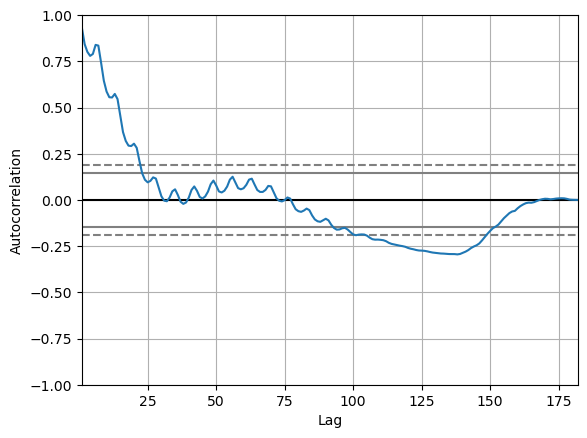

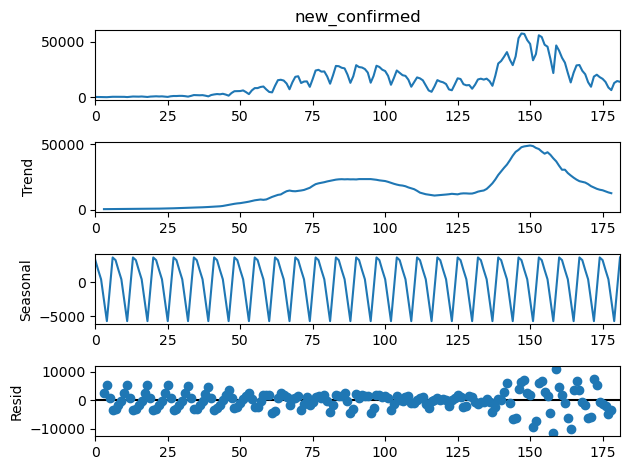

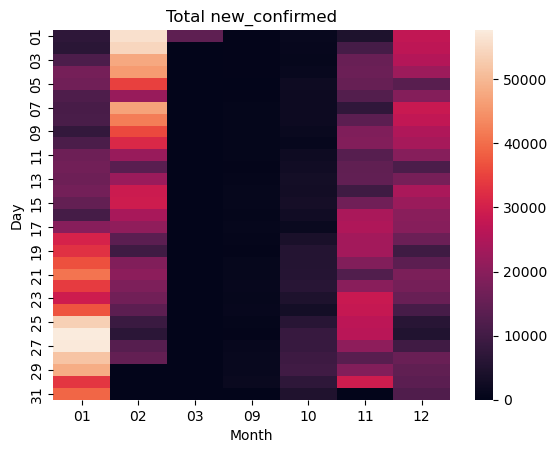

In [53]:
#2.2. Wykorzystaj do analizy trendów analizę szeregów czasowych (autoregresja, średnia ruchoma, modele autoregresyjne), 
#która umożliwi zbadanie danych zebranych w Twoich bazach w danym okresie czasu.
import seaborn as sns
# wykres przedstawiający autokorelacje w całym okresie
x = pd.plotting.autocorrelation_plot(df['new_confirmed'])
x.plot()
plt.show()

decompose = seasonal_decompose(df['new_confirmed'],model='additive', period=7)
decompose.plot()
plt.show()

tmp = df.pivot(index="Day", columns="Month", values="new_confirmed")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total new_confirmed")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

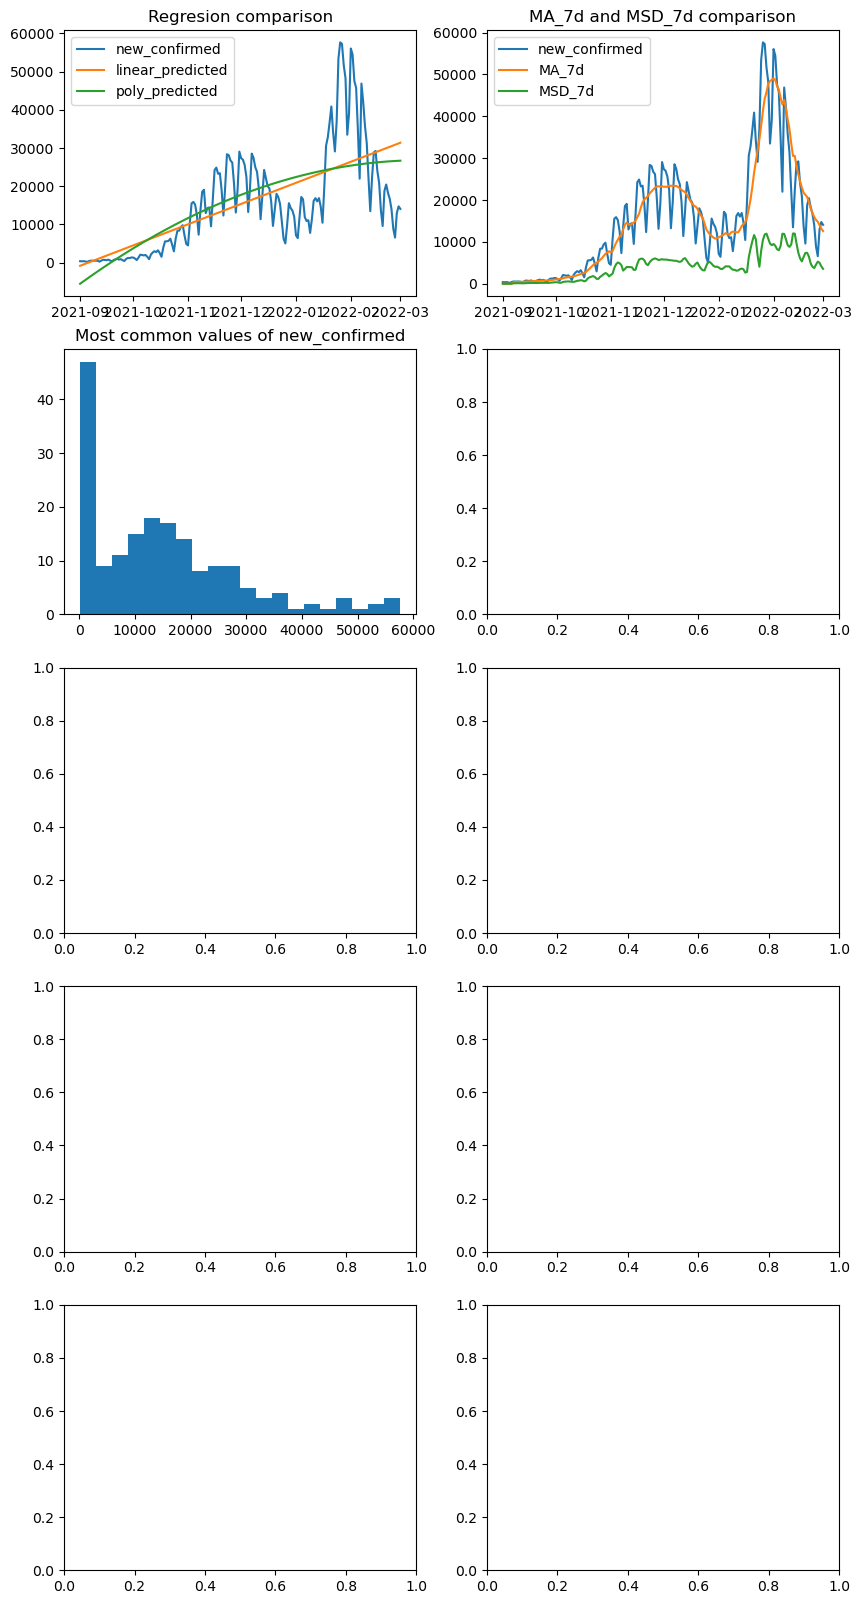

In [51]:
#3.1. Przedstaw wyniki analizy regresji, trendów i ew. wykrywania anomalii za pomocą wykresów 
#liniowych/punktowych/histogramów/map cieplnych etc. do zilustrowania otrzymanych wyników (min. 10 różnych wizualizacji).
#1. Porównanie wynikow obu regresji z pobranymi danymi wczesniej danymi
df['date']=df['date'].map(dt.datetime.toordinal)
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
linear_predicted = lr.predict(df['date'].values.reshape(-1,1))
poly_predicted = lr2.predict(pr.fit_transform(df[['date']]))
df['date']=df['date'].map(dt.datetime.fromordinal)
ax[0, 0].plot(df['date'], df['new_confirmed'], label ='new_confirmed')
ax[0, 0].plot(df['date'], linear_predicted, label ='linear_predicted')
ax[0, 0].plot(df['date'], poly_predicted, label ='poly_predicted')
ax[0, 0].legend(loc = 2)
ax[0, 0].set_title("Regresion comparison")

#2. Rozłożenie wartosci new_confirmed
ax[1, 0].hist(df['new_confirmed'], 20, histtype='bar')
ax[1, 0].set_title("Most common values of new_confirmed")

#3. Wizualizacja zmiany w czasie wartości średniej kroczącej i odchylenia standardowego kroczacego
ax[0, 1].plot(df['date'], df['new_confirmed'], label ='new_confirmed')
ax[0, 1].plot(df['date'], df['MA_7d'], label ='MA_7d')
ax[0, 1].plot(df['date'], df['MSD_7d'], label ='MSD_7d')
ax[0, 1].legend(loc = 2)
ax[0, 1].set_title("MA_7d and MSD_7d comparison")
plt.show()

#4. 
#ax[1, 1].pcolormesh(df['Month'], df['Day'], df['new_confirmed'])

#3.2. Przygotuj zwięzły raport korespondujący z danymi zwizualizowanymi, zawierający syntetyczne podsumowanie Twoich działań.